In [1]:
import time

from osm_runner import Runner  # pip install osm-runner
import pandas as pd

from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
import geopy
from geopy import distance

In [2]:
def str_to_cord(x):
    lat,long = float(x.split(",")[0]),float(x.split(",")[1])
    return lat,long

In [3]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="college"](area);
 way["amenity"="college"](area);
 rel["amenity"="college"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data_university = response.json()

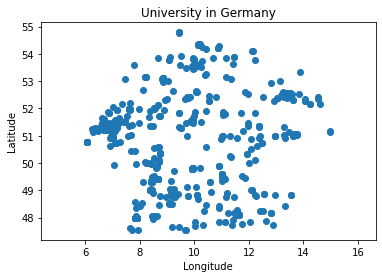

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Collect coords into list
coords = []
for element in data_university['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))
# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('University in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [7]:
import pandas as pd
df = pd.DataFrame()

In [8]:
df["lat"] = X[:, 1]
df["long"] =X[:, 0]
df["dummy"] = df.lat.apply(lambda x: str(round(x,5)))
df["dummy1"] = df.long.apply(lambda x: "," +str(round(x,5)))
df["dummy2"] = df.dummy+df.dummy1
df["cord"] = df.dummy2.apply(lambda x: str_to_cord(x))
df.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [9]:
df.head()

,lat,long,cord
0,51.436064,6.652637,"(51.43606, 6.65264)"
1,52.637578,9.214239,"(52.63758, 9.21424)"
2,53.160360,8.212838,"(53.16036, 8.21284)"
3,51.496840,7.103350,"(51.49684, 7.10335)"
4,51.513944,7.118579,"(51.51394, 7.11858)"


In [10]:
dn =pd.read_pickle("stats.pickle")
#dn= dn[["city","latitude","longitude","park_id","postal_code"]]
dn["dummy"] = dn.latitude.apply(lambda x: str(round(x,5)))
dn["dummy1"] = dn.longitude.apply(lambda x: "," +str(round(x,5)))
dn["dummy2"] = dn.dummy+dn.dummy1
dn["cord"] = dn.dummy2.apply(lambda x: str_to_cord(x))
dn.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [36]:
def  filter_lat_long(cord,th=0.1):
    la1,ln1 = cord
    dk = df.copy()
    return(
    dk
        [dk["lat"]<=la1+th]
        [dk["lat"]>=la1-th]
        [dk["long"]<=ln1+th]
        [dk["long"]>=ln1-th])


In [25]:
filter_lat_long(dn.cord.iloc[0],th=0.5)

<ipython-input-24-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


,lat,long,cord
353,48.251374,12.420940,"(48.25137, 12.42094)"
369,47.869139,12.647721,"(47.86914, 12.64772)"
458,48.255940,12.526903,"(48.25594, 12.5269)"
478,48.172182,12.832015,"(48.17218, 12.83201)"
488,48.154917,12.829733,"(48.15492, 12.82973)"
489,48.169336,12.831315,"(48.16934, 12.83132)"
542,47.850625,12.060635,"(47.85062, 12.06064)"


In [26]:
def nearest(c,th=0.1):
    dk = filter_lat_long(cord = c,th=th)
    if(len(dk)>0):
        dk["distance"] = dk.cord.apply(lambda x: distance.distance(c,x))
        dk = dk.sort_values("distance",ascending = True)
        v  = dk.distance.iloc[0].km
    else:
        v = 1000
    return v

In [34]:
nearest(dn.cord.iloc[0],th=0.2)

<ipython-input-24-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


1000

In [37]:
dn["Nearest_university_km"] = dn.cord.apply(lambda x :nearest(x,th=0.2))

<ipython-input-36-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


In [38]:
dn

,evse_id,datetime_start,datetime_stop,city,park_id,latitude,longitude,postal_code,year,month,...,Temperature,Precipitation,clc_code,area_code,Population_Density,Count_Charging,Charging_time_in_hours_log,Charging_time_in_min_log,cord,Nearest_university_km
0,hj_AT*HTB*E100011,2019-02-10 10:28:53.836,2019-02-10 12:54:11.750,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,5.133333,0.0,Industrial,057740032032,844.328749,159,0.884341,4.978686,"(47.8772, 12.3372)",1000.000000
1,hj_AT*HTB*E100011,2019-02-15 08:33:09.428,2019-02-15 12:37:18.549,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,-2.233333,0.0,Industrial,057740032032,844.328749,159,1.403438,5.497783,"(47.8772, 12.3372)",1000.000000
2,hj_AT*HTB*E100011,2019-02-19 14:12:56.548,2019-02-19 18:55:34.738,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,12.133333,0.0,Industrial,057740032032,844.328749,159,1.549806,5.644150,"(47.8772, 12.3372)",1000.000000
3,hj_AT*HTB*E100011,2019-02-23 09:05:08.119,2019-02-23 14:41:49.291,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,-1.133333,0.0,Industrial,057740032032,844.328749,159,1.724798,5.819143,"(47.8772, 12.3372)",1000.000000
4,hj_AT*HTB*E100011,2019-02-25 11:32:44.019,2019-02-25 12:27:19.368,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,7.666667,0.0,Industrial,057740032032,844.328749,159,-0.094616,3.999729,"(47.8772, 12.3372)",1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509029,sl_23901984,2021-05-19 09:50:45.000,2021-05-19 20:01:17.000,Niestetal,sl_23897386,51.3144,9.5549,34266,2021,May,...,9.933333,0.0,Urban,051120000000,2142.121993,216,2.319988,6.414333,"(51.3144, 9.5549)",3.657024
1509030,sl_23901984,2021-05-21 09:46:36.000,2021-05-21 20:33:36.000,Niestetal,sl_23897386,51.3144,9.5549,34266,2021,May,...,15.966667,0.0,Urban,051120000000,2142.121993,216,2.378002,6.472346,"(51.3144, 9.5549)",3.657024
1509031,sl_23901984,2021-05-23 17:09:38.000,2021-05-23 17:10:45.000,Niestetal,sl_23897386,51.3144,9.5549,34266,2021,May,...,14.466667,0.0,Urban,051120000000,2142.121993,216,-3.983997,0.110348,"(51.3144, 9.5549)",3.657024
1509032,sl_23901984,2021-05-25 09:52:07.000,2021-05-25 21:03:31.000,Niestetal,sl_23897386,51.3144,9.5549,34266,2021,May,...,9.833333,0.0,Urban,051120000000,2142.121993,216,2.415021,6.509365,"(51.3144, 9.5549)",3.657024


In [39]:
dn.to_pickle("university_OSM.pickle")

In [40]:
dn.to_csv("university_OSM.csv")